In [52]:
import pandas as pd

df_raw = pd.read_csv('./consolidado_marzo_metrics.csv')

In [53]:
df_raw.head()

,enbAgg,enodeb,cell,userDlAvrgThroughputKbps,prbDlUtilizationRate,trafficDUserDlGb,usersAvg,vendor,municipio,banda,sector,time,sectorcompleto
0,AGUAGU0002,AGUAGU0002,MLAGUAGU0002_1_A,1255.33,6.35,0.0002,0.33,HUAWEI,Aguascalientes,A,1,2023-02-28 00:00:00,AGUAGU0002-1
1,AGUAGU0002,AGUAGU0002,MLAGUAGU0002_1_A,1874.26,6.10,0.0001,0.16,HUAWEI,Aguascalientes,A,1,2023-02-28 01:00:00,AGUAGU0002-1
2,AGUAGU0002,AGUAGU0002,MLAGUAGU0002_1_A,3749.73,6.01,0.0007,0.56,HUAWEI,Aguascalientes,A,1,2023-02-28 02:00:00,AGUAGU0002-1
3,AGUAGU0002,AGUAGU0002,MLAGUAGU0002_1_A,2299.28,5.95,0.0001,0.40,HUAWEI,Aguascalientes,A,1,2023-02-28 03:00:00,AGUAGU0002-1
4,AGUAGU0002,AGUAGU0002,MLAGUAGU0002_1_A,1615.05,5.96,0.0003,0.44,HUAWEI,Aguascalientes,A,1,2023-02-28 04:00:00,AGUAGU0002-1


In [54]:

import pandas as pd
import numpy as np
from random import randint,choice


# Read the data into a pandas DataFrame
df_raw = pd.read_csv('./consolidado_marzo_metrics.csv',parse_dates=['time'])

# Ensure the data is sorted by 'cell' and 'time'
df = df_raw.sort_values(['cell', 'time'])

nodes_dict = df.groupby(['cell','enodeb'])
# Group the data by 'cell'
grouped = df.groupby('cell')

# Create a list to store the FFT results
fft_results = []

def get_cell_enodeb_mapping(dataframe):
    """
    Groups all combinations of 'enodeb' and 'cell' and returns a dictionary
    with the structure {"cell_name": "enodeb_name"}.
    
    Parameters:
    - dataframe: pandas DataFrame containing at least 'cell' and 'enodeb' columns.
    
    Returns:
    - A dictionary mapping cell names to enodeb names.
    """
    # Drop duplicates to get unique combinations
    unique_combinations = dataframe[['cell', 'enodeb']].drop_duplicates()
    # Create the mapping dictionary
    mapping_dict = unique_combinations.set_index('cell')['enodeb'].to_dict()
    return mapping_dict

def get_cell_sector_mapping(dataframe):
    """
    Groups all combinations of 'enodeb' and 'cell' and returns a dictionary
    with the structure {"cell_name": "enodeb_name"}.
    
    Parameters:
    - dataframe: pandas DataFrame containing at least 'cell' and 'enodeb' columns.
    
    Returns:
    - A dictionary mapping cell names to enodeb names.
    """
    # Drop duplicates to get unique combinations
    unique_combinations = dataframe[['cell', 'sectorcompleto']].drop_duplicates()
    # Create the mapping dictionary
    mapping_dict = unique_combinations.set_index('cell')['sectorcompleto'].to_dict()
    return mapping_dict



cell_enodeb_mapping = get_cell_enodeb_mapping(df_raw)
cell_sector_mapping = get_cell_sector_mapping(df_raw)


# For each cell, compute the FFT of 'trafficDUserDlGb'
for cell_name, group in grouped:
    # Get the traffic data
    traffic = group['trafficDUserDlGb'].values
    # Compute the FFT
    fft_coeffs = np.fft.fft(traffic)
    # Store the result in a DataFrame
    fft_df = pd.DataFrame({
        'cell': cell_name,
        'fft_coefficients': [fft_coeffs],
        'enodeb': cell_enodeb_mapping[cell_name],
        'sectorcompleto': cell_sector_mapping[cell_name]
    })
    fft_results.append(fft_df)

# Combine all FFT results into a single DataFrame
fft_df = pd.concat(fft_results, ignore_index=True)



In [55]:
def adjust_fft_coefficients(fft_coeffs, n):
    original_n = len(fft_coeffs)
    if n != original_n:
        # Zero-pad or truncate the FFT coefficients to match the desired length
        if n > original_n:
            # Zero-pad
            fft_coeffs_padded = np.zeros(n, dtype=complex)
            fft_coeffs_padded[:original_n] = fft_coeffs
            fft_coeffs = fft_coeffs_padded
        else:
            # Truncate
            fft_coeffs = fft_coeffs[:n]
    return fft_coeffs

def generate_traffic(start_time, end_time, type='cell', freq='h'):
    """
    Generate synthetic traffic data based on the FFT coefficients.

    Parameters:
    - start_time: Start time of the time window (string or datetime).
    - end_time: End time of the time window (string or datetime).
    - type: 'cell', 'node', or 'sector'. Default is 'cell'.
    - freq: Frequency string for time intervals (default is 'H' for hourly).

    Returns:
    - A pandas DataFrame with the generated traffic data.
    """
    # Generate the time index
    times = pd.date_range(start=start_time, end=end_time, freq=freq)
    n = len(times)
    
    if type == 'cell':
        # Pick a random cell
        cell_row = fft_df.sample(n=1)
        cell = cell_row['cell'].values[0]
        fft_coeffs = cell_row['fft_coefficients'].values[0]
        fft_coeffs = np.array(fft_coeffs, dtype=complex)
        
        # Adjust the FFT coefficients
        fft_coeffs = adjust_fft_coefficients(fft_coeffs, n)
        
        # Reconstruct the signal
        reconstructed_signal = np.fft.ifft(fft_coeffs).real
        
        # Create DataFrame
        generated_df = pd.DataFrame({
            'time': times,
            'cell': cell,
            'generated_trafficDUserDlGb': reconstructed_signal
        })
        return generated_df
    
    elif type == 'node':
        # Pick a random enodeb
        enodeb_row = fft_df[['enodeb']].drop_duplicates().sample(n=1)
        enodeb = enodeb_row['enodeb'].values[0]
        # Get all cells under this enodeb
        cells = fft_df[fft_df['enodeb'] == enodeb]
        
        total_signal = np.zeros(n)
        for idx, row in cells.iterrows():
            fft_coeffs = np.array(row['fft_coefficients'], dtype=complex)
            fft_coeffs = adjust_fft_coefficients(fft_coeffs, n)
            reconstructed_signal = np.fft.ifft(fft_coeffs).real
            total_signal += reconstructed_signal
        
        # Create DataFrame
        generated_df = pd.DataFrame({
            'time': times,
            'enodeb': enodeb,
            'generated_trafficDUserDlGb': total_signal
        })
        return generated_df
    
    elif type == 'sector':
        # Pick a random sectorcompleto
        sector_row = fft_df[['sectorcompleto']].drop_duplicates().sample(n=1)
        sectorcompleto = sector_row['sectorcompleto'].values[0]
        # Get all cells under this sectorcompleto
        cells = fft_df[fft_df['sectorcompleto'] == sectorcompleto]
        
        total_signal = np.zeros(n)
        for idx, row in cells.iterrows():
            fft_coeffs = np.array(row['fft_coefficients'], dtype=complex)
            fft_coeffs = adjust_fft_coefficients(fft_coeffs, n)
            reconstructed_signal = np.fft.ifft(fft_coeffs).real
            total_signal += reconstructed_signal
        
        # Create DataFrame
        generated_df = pd.DataFrame({
            'time': times,
            'sectorcompleto': sectorcompleto,
            'generated_trafficDUserDlGb': total_signal
        })
        return generated_df
    
    else:
        raise ValueError("Type must be 'cell', 'node', or 'sector'.")

# Example usage
start_time = '2023-03-01 00:00:00'
end_time = '2023-03-01 02:00:00'

# Generate traffic for a random cell
generated_data_cell = generate_traffic(start_time, end_time, type='cell')
print("Generated Data (Cell):")
print(generated_data_cell)

# Generate traffic for a random node
generated_data_node = generate_traffic(start_time, end_time, type='node')
print("\nGenerated Data (Node):")
print(generated_data_node)

# Generate traffic for a random sector
generated_data_sector = generate_traffic(start_time, end_time, type='sector')
print("\nGenerated Data (Sector):")
print(generated_data_sector)

Generated Data (Cell):
                 time              cell  generated_trafficDUserDlGb
0 2023-03-01 00:00:00  MLJALGDL2828_1_K                  316.752360
1 2023-03-01 01:00:00  MLJALGDL2828_1_K                  329.768752
2 2023-03-01 02:00:00  MLJALGDL2828_1_K                  348.128189

Generated Data (Node):
                 time      enodeb  generated_trafficDUserDlGb
0 2023-03-01 00:00:00  JALGDL1937                 1118.800591
1 2023-03-01 01:00:00  JALGDL1937                 1173.846089
2 2023-03-01 02:00:00  JALGDL1937                 1147.956620

Generated Data (Sector):
                 time sectorcompleto  generated_trafficDUserDlGb
0 2023-03-01 00:00:00   JALGDL0641-3                  175.475692
1 2023-03-01 01:00:00   JALGDL0641-3                  179.912413
2 2023-03-01 02:00:00   JALGDL0641-3                  179.496294


<Axes: title={'center': 'Smoothed Traffic Data'}, xlabel='time'>

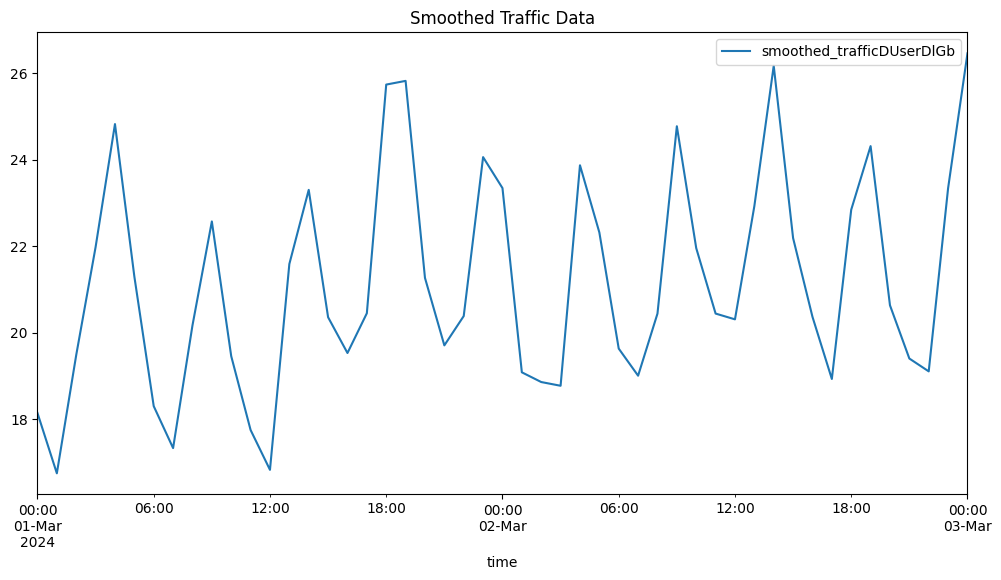

In [66]:
# Example usage
start_time = '2024-03-01 00:00:00'
end_time = '2024-03-03 00:00:00'

generated_data =generate_traffic(start_time, end_time, type='cell')
# Smooth the generated data using a rolling average
generated_data['smoothed_trafficDUserDlGb'] = generated_data['generated_trafficDUserDlGb'].rolling(window=3, min_periods=1).mean()

# Plot the smoothed data
generated_data.plot(x='time', y='smoothed_trafficDUserDlGb', figsize=(12, 6), title='Smoothed Traffic Data')

